In [1]:
import torch
import torch.nn as nn
import numpy as np

In [2]:
from matplotlib import pyplot
from pprint import pprint
%matplotlib inline

## Functions

#### Compute the value of Y using sigma

In [3]:
def computeY(X, sigma) :
    mu = 0 
    return np.cos(2*np.pi*X) + (sigma*np.random.randn(X.size,1)+mu)

#### Generate X and Y

In [4]:
def getData(N, sigma):
    #np.random.seed(40)
    X = np.random.uniform(low=0,high=1.0,size=(N,1))
    #X = torch.sort(X).values
    Y = computeY(X, sigma)
    X = torch.tensor(X,dtype=torch.float32)
    Y = torch.tensor(Y,dtype=torch.float32)
    return X, Y

#### Transform X into a tensor of N by d

In [5]:
def createNbyDPolynomial(X,N,d):
    XPoly = torch.ones((N,d+1))
    for i in range(N):
        for j in range(1,d+1):
            XPoly[i,j] = X[i]**j
    return XPoly

In [6]:
def getXY(X,Y,N,d):
    XPoly = createNbyDPolynomial(X,N,d)
    return XPoly, Y

In [7]:
def getTrainingData(XPoly, Y):
    indexes = np.arange(N)
    np.random.shuffle(indexes)
    
    trainingDataSize = int(len(X) * 0.8)
    if trainingDataSize == 0 :
        trainingDataSize = 1
    
    trainingIndexes = indexes[:trainingDataSize]
    valIndexes = indexes[trainingDataSize:]

    XTrain, YTrain = XPoly[trainingIndexes], Y[trainingIndexes]
    XVal, YVal = XPoly[valIndexes], Y[valIndexes]
    
    return XTrain, YTrain, XVal, YVal, trainingIndexes

#### Mean Squared Error Functions

In [8]:
def getMSE(Y, Ybar) :
    error = Y-Ybar
    mse =  error ** 2
    return mse.mean(), error

In [9]:
def getMSEReg(Y,Ybar,theta,reg):
    error = Y-Ybar
    errSquared = error ** 2
    mse =  errSquared.mean()
    sumThetaSq = torch.sum(theta**2, dim=0)
    mseReg = mse + (reg*sumThetaSq)
    return mseReg, error

#### Computes Mini Batch Stochastic Gradient Descent

In [10]:
def computeMiniBatchGrad(batchSize, error, XTrain):
    trainingIndexes = np.arange(len(XTrain))
    # shuffle indexes so we aren't picking the same training samples
    np.random.shuffle(trainingIndexes)
    # take a [batchSize] of the training indexes and 
    batchIndexes = trainingIndexes[:batchSize]
    XSGD, ErrSGD = XTrain[batchIndexes], error[batchIndexes]
    grad = -2 * torch.mm(torch.t(XSGD), ErrSGD)
    #grad = -2 * torch.mm(XSGD.reshape(-1,1), ErrSGD)
    # we can't take the mean of the gradient here because the summation has already happened in the matrix multiplication
    # all we need to do is divide the individual values by the batch size
    return grad/batchSize

#### Manual Updating of Coefficients

In [11]:
def updateParams(theta, lrate, grad):
    return theta - (lrate * grad)

In [12]:
def updateParamsReg(theta,lrate,grad,reg):
    gradReg = 2*reg*theta
    return theta - (lrate * (grad+gradReg))

In [13]:
def initTheta(d) :
    # The bias b is absorbed into theta as b(knot) and 1 is absorbed into X as X(knot)
    # start with d+1 randomly generated normal distribution
    theta = torch.tensor(np.random.uniform(low=0,high=1.0,size=(d+1,1)),dtype=torch.float32)#assuming d = 2. will become d+1
    return theta

#### Fit & Fit Data

In [14]:
# should be plotting the MSE vs number of runs : run till convergence
def fit(XTrain,YTrain,d,reg):
    prevMSE = 0
    currentMSE = 0
    lrate = 1e-1
    theta = initTheta(d)
    N = len(XTrain)
    
    for i in range(5000):
        # set previous mean squared error to current mean squared error
        prevMSE = currentMSE
        # calculate the estimated Y(bar) using there and X train
        Ybar = torch.mm(XTrain,theta)
        # calculate the mean squared error between true Y and estimated Y
        currentMSE, err = getMSEReg(YTrain, Ybar, theta, reg)
        # compute mini batch stochastic gradient descent
        gradient = computeMiniBatchGrad(int(0.5*N), err, XTrain)
        # update the parameters of theta using the old theta, the learning rate and the gradient
        theta = updateParamsReg(theta, lrate, gradient, reg)
        
    return currentMSE, theta
        

In [15]:
def fitData(XTrain,YTrain,N,d,sigma,reg=False):
    #eIns, epochs, theta = fit(XTrain,YTrain,d)
    eIn, theta = fit(XTrain,YTrain,d,reg)
    X,YTest,YTestbar,YTestErr,eOut = runTest(1500,sigma,d,theta,reg)
    return theta, eIn, eOut

In [16]:
def runTest(testN,sigma,d,theta,reg):
    X,Y = getData(testN,sigma)
    XTest, YTest = getXY(X,Y,testN,d)
    YTestbar = torch.mm(XTest,theta)
    mse, YTestErr = getMSEReg(YTest,YTestbar,theta,reg)
    return X,YTest,YTestbar,YTestErr,mse

#### Experiments for 50 trials

In [17]:
def experiment(N,d,sigma,reg) :
    trials = 50
    eIns = torch.empty(trials,1,dtype=torch.float32)
    eOuts = torch.empty(trials,1,dtype=torch.float32)
    thetas = torch.empty(trials,d+1,dtype=torch.float32)
    for i in range(trials):
        X,Y = getData(N,sigma)
        XTrain, YTrain = getXY(X,Y,N,d)
        theta, eIn, eOut = fitData(XTrain,YTrain,N,d,sigma,reg)
        #print(eIn,eOut,theta)
        #thetas[i], eIns[i], eOuts[i] = theta.reshape(-1,1), eIn, eOut
        thetas[i], eIns[i], eOuts[i] = torch.t(theta), eIn, eOut
    eIn, eOut = np.nanmean(eIns.numpy()), np.nanmean(eOuts.numpy())
    # find mean over each column
    thetaNP = np.nanmean(thetas.numpy(),axis=0)
    theta = torch.tensor(thetaNP)
    theta = theta.reshape(-1,1)
    # initialize size of testN
    X,YTest,YTestbar,YTestErr,eBias = runTest(1500,sigma,d,theta,reg)
    
    return X, YTest, YTestbar, eIn, eOut, eBias

In [18]:
# setting reg to True means activating regularization - weight decay
def experimentResult(N,d,sigma,reg) :
    X,Y,YBar,eIn,eOut,eBias = experiment(N,d,sigma,reg)
    print(f"Combination : {[N,d,sigma]} \t Training Error : {eIn} \t Testing Error : {eOut} \t Bias : {eBias}")
     #'''
    pyplot.scatter(X.numpy(),Y.numpy())
    pyplot.plot(X,YBar,'ro')
    pyplot.legend(['Estimated', 'Original'])
    #'''
    return eIn,eOut,eBias

Combination : [100, 10, 0.01] 	 Training Error : 0.011021670885384083 	 Testing Error : 0.011607822962105274 	 Bias : tensor([0.0108])


(0.011021671, 0.011607823, tensor([0.0108]))

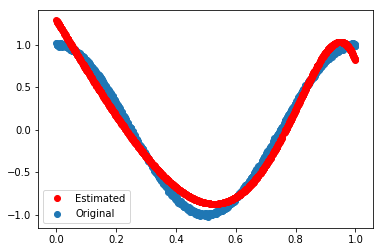

In [19]:
experimentResult(100,10,0.01,0)

Combination : [100, 10, 0.01] 	 Training Error : 0.009353947825729847 	 Testing Error : 0.010019579902291298 	 Bias : tensor([0.0098])


(0.009353948, 0.01001958, tensor([0.0098]))

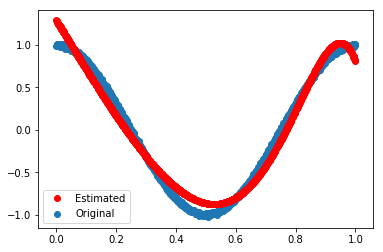

In [20]:
experimentResult(100,10,0.01,-2e-5)

Combination : [100, 10, 0.01] 	 Training Error : 0.010070424526929855 	 Testing Error : 0.010877124965190887 	 Bias : tensor([0.0108])


(0.0100704245, 0.010877125, tensor([0.0108]))

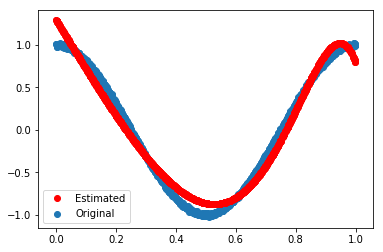

In [21]:
experimentResult(100,10,0.01,-1e-5)

In [22]:
NList = [2,5,10,20,50,100,200]
dList = np.arange(0,21)
sigmas = [0.01,0.1,1]
#print(NList,dList, sigma)

#### Run Experiments For Combinations

In [23]:
def runExperiments(reg):
    results = []
    for N in NList:
        for d in dList:
            for sigma in sigmas:
                X,Y,YBar,eIn,eOut,eBias = experiment(N,d,sigma,reg)
                print(f"Combination : {[N,d,sigma]} \t Training Error : {eIn} \t Testing Error : {eOut} \t Bias : {eBias.numpy()[0]}")
                results.append([N,d,sigma,eIn.item(),eOut.item(),eBias.item()])

    with open (f"./results/experiments_weight_decay_{reg}",'w', encoding="utf-8") as f:
        pprint(results, f)         

In [ ]:
runExperiments(0)

In [ ]:
runExperiments(-2e-5)

In [ ]:
runExperiments(-1e-5)

## Testing

In [ ]:
# should be plotting the MSE vs number of runs : run till convergence
def fitPlay(XTrain, YTrain, d):
    prevMSE = 0
    currentMSE = 0
    epoch = 0
    epochs = []
    mses = []
    lrate = 1e-1
    theta = initTheta(d)
    N = len(XTrain)
    
    for i in range(5000):
        # set previous mean squared error to current mean squared error
        prevMSE = currentMSE
        # calculate the estimated Y(bar) using there and X train
        
        Ybar = torch.mm(XTrain,theta)
        # calculate the mean squared error between true Y and estimated Y
        currentMSE, err = getMSE(YTrain, Ybar)
        # track mean squared errors
        mses.append(currentMSE)
        
        # compute mini batch stochastic gradient descent
        gradient = computeMiniBatchGrad(int(0.5*N), err, XTrain)
        # update the parameters of theta using the old theta, the learning rate and the gradient
        theta = updateParams(theta, lrate, gradient)
        epoch += 1
        epochs.append(epoch)
        print(f"mean squared error : {currentMSE} \t epoch:{epoch}")
        
        #if (currentMSE - prevMSE) == 0:
            #break
    return currentMSE, theta, mses, epochs
        

In [ ]:
def fitDataPlay(XTrain, YTrain, N, d, sigma):
    eIn, theta, mses, epochs = fitPlay(XTrain, YTrain, d)
    return mses, epochs, theta
'''
    XTest, YTest = getTestData(1000, sigma, d)
    YTestbar = torch.mm(XTest,theta)
    eOut, errTest = getMSE(YTest, YTestbar)
    return theta, eIns, eOut
    '''

In [ ]:
N = 100
d = 10
X, Y = getData(N, 0.01)
print(X.size(), Y.size())
pyplot.plot(X.numpy(),Y.numpy(),'ro')

In [ ]:
XPoly = createNbyDPolynomial(X, N, d)

In [ ]:
mses, epochs, theta = fitDataPlay(XPoly, Y, N, d, 1)

In [ ]:
print(theta)
print(theta.shape)
mse_arr = np.array(mses)
print(len(mse_arr))
epoch_arr = np.array(epochs)
print(len(epoch_arr))
print(mse_arr[-1])

In [ ]:
pyplot.plot(epoch_arr, mse_arr, 'y--')

In [ ]:
YNew = torch.mm(XPoly,theta)
#print(YNew)

In [ ]:
pyplot.plot(X, Y, 'ro')
pyplot.plot(X, YNew, 'go')
pyplot.legend(['Cosine', 'Poly'])